In [1]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [2]:
import keras
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from sklearn import preprocessing

from cataclop.ml import preprocessing as cataclop_preprocessing

In [3]:
from cataclop.ml.pipeline import factories

dataset = factories.Dataset.factory('default', params={
    "from": "2018-01-01",
    "to": "2019-12-31",
    "categories": ["PLAT"],
    "countries": ["FRA"],
    "sub_categories": ["GROUPE_I", "GROUPE_II", "GROUPE_III", "HANDICAP", "HANDICAP_DIVISE"]
})
dataset.load(force=True)

2432 races


In [4]:
race_features = ['prize', 'declared_player_count']
race_features += ['odds_{:d}'.format(i) for i in range(10)]


horse_features = ['age', 'final_odds_ref', 'final_odds_ref_r'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

for f in dataset.agg_features:
        if f.startswith('final_odds'):
            continue
        horse_features.append(f)
        horse_features.append('{}_r'.format(f))
        #for s in dataset.agg_features_funcs:
            #features.append('{}_{}'.format(f, s[0]))

horse_cat_features = ['horse_sex', 'horse_breed']
race_cat_features = ['category', 'sub_category']

race_features = sorted(list(set(race_features)))
horse_features = sorted(list(set(horse_features)))
horse_cat_features = sorted(list(set(horse_cat_features)))
race_cat_features = sorted(list(set(race_cat_features)))

features = race_features + horse_features
cat_features = race_cat_features + horse_cat_features

print(features)
print(cat_features)


['declared_player_count', 'odds_0', 'odds_1', 'odds_2', 'odds_3', 'odds_4', 'odds_5', 'odds_6', 'odds_7', 'odds_8', 'odds_9', 'prize', 'age', 'final_odds_ref', 'final_odds_ref_r', 'handicap_distance', 'handicap_distance_r', 'handicap_weight', 'handicap_weight_r', 'hist_1_days', 'hist_1_days_r', 'hist_1_pos', 'hist_1_pos_r', 'hist_2_days', 'hist_2_days_r', 'hist_2_pos', 'hist_2_pos_r', 'hist_3_days', 'hist_3_days_r', 'hist_3_pos', 'hist_3_pos_r', 'hist_4_pos', 'hist_5_pos', 'hist_6_pos', 'placed_2_count', 'placed_2_count_r', 'placed_3_count', 'placed_3_count_r', 'placed_earnings', 'placed_earnings_r', 'post_position', 'post_position_r', 'prev_year_earnings', 'prev_year_earnings_r', 'race_count', 'race_count_r', 'trainer_avg_winning_dividend', 'trainer_avg_winning_dividend_r', 'trainer_winning_rate', 'trainer_winning_rate_r', 'trueskill_mu', 'trueskill_mu_r', 'trueskill_sigma', 'trueskill_sigma_r', 'victory_count', 'victory_count_r', 'victory_earnings', 'victory_earnings_r']
['category',

In [5]:
NAN_FLAG = 0

df = dataset.players.copy()
df = df.groupby('race_id').filter(lambda r: (r['trueskill_mu'] == 25).sum() < r['declared_player_count'].max()/2 and r['position'].min() == 1 and r['winner_dividend'].max() > 0 and r['odds_0'].min() != dataset.params['nan_flag'] and r['odds_1'].min() != dataset.params['nan_flag'] )
df.reset_index(inplace=True)
df.loc[:, features] = df.loc[:, features].fillna(NAN_FLAG)

df['position'] = df['position'].fillna(20)

scaler = preprocessing.RobustScaler() 
scaled = scaler.fit_transform(df.loc[:, features].values)

df['declared_player_count_real'] = df['declared_player_count'].copy()
df['prize_real'] = df['prize'].copy()
df.loc[:, features] = scaled

In [6]:
horse_dummies = cataclop_preprocessing.get_dummies(df, horse_cat_features, limit=5)

df_horse_dummies = cataclop_preprocessing.get_dummy_values(df, horse_dummies)

df = pd.concat([df, df_horse_dummies], axis=1)

race_dummies = cataclop_preprocessing.get_dummies(df, race_cat_features, limit=5)

df_race_dummies = cataclop_preprocessing.get_dummy_values(df, race_dummies)

df = pd.concat([df, df_race_dummies], axis=1)


all_horse_features = list(set(horse_features + list(df_horse_dummies.columns)))

all_race_features = list(set(race_features + list(df_race_dummies.columns)))

print(len(all_horse_features), all_horse_features)
print(len(all_race_features), all_race_features)

56 ['hist_3_pos', 'hist_6_pos', 'horse_breed_value_AQPS', 'trainer_avg_winning_dividend', 'race_count', 'handicap_weight', 'hist_3_days_r', 'placed_3_count_r', 'hist_5_pos', 'horse_sex_value_PUR-SANG', 'hist_1_days_r', 'hist_2_days_r', 'handicap_distance_r', 'post_position_r', 'hist_2_days', 'post_position', 'horse_sex_value_AQPS', 'horse_breed_value_INCONNU', 'victory_count_r', 'placed_earnings', 'horse_breed_value_PUR-SANG', 'hist_1_days', 'prev_year_earnings', 'hist_3_pos_r', 'placed_2_count_r', 'trainer_winning_rate_r', 'horse_sex_value_INCONNU', 'prev_year_earnings_r', 'placed_3_count', 'trueskill_sigma', 'trueskill_sigma_r', 'victory_count', 'victory_earnings_r', 'hist_1_pos_r', 'hist_2_pos', 'final_odds_ref_r', 'handicap_distance', 'hist_1_pos', 'placed_2_count', 'hist_4_pos', 'trueskill_mu', 'horse_breed_value_TROTTEUR FRANCAIS', 'horse_breed_value_TROTTEUR ETRANGER', 'final_odds_ref', 'horse_sex_value_TROTTEUR ETRANGER', 'race_count_r', 'handicap_weight_r', 'placed_earnings_r'

In [8]:

def make_Xy(df, train=True):

    races = df.groupby('race_id')
    n_races = len(races)

    n_features = len(features)
    X = []
    y = []

    # keep track of the raw data position in the dataset 
    back_idx = []

    for race_id, race in tqdm(races, total=n_races):
        n_players = len(race)


        for i in range(n_players):
            player1 = race.iloc[i]
            x1 = player1[all_horse_features].values

            # only train on 4 first
            if train and (player1['position'] == 0 or player1['position'] == 20 ):
                continue
                
            c = player1['declared_player_count_real']

            for j in range(n_players):
                if j == i:
                    continue
                player2 = race.iloc[j]

                # only train on 4 first
                if train and (player2['position'] == 0 or player2['position'] == 20):
                    continue

                x2 = player2[all_horse_features].values

                row_x = np.concatenate((x1, x2, player1[all_race_features]))
                
                if not train:
                    row_y = 0
                else:
                
                    if c == 0:
                        continue
                        
                    p = (player2['position'] - player1['position']) / c
                
                    row_y = p

                X.append(row_x)
                y.append(row_y)

                back_idx.append((race.index[i], race.index[j]))

    X = np.array(X)
    X = X.astype(np.float32)

    y = np.array(y)
    y = y.astype(np.float32)
                
    return (X, y, back_idx)
    

In [9]:
race_ids = df['race_id'].unique()
test_portion = int(len(race_ids) * 0.2)
test_race_ids = race_ids[0:test_portion]
train_race_ids = race_ids[test_portion+1:]

df_train = df[df['race_id'].isin(train_race_ids)].copy()
df_test = df[df['race_id'].isin(test_race_ids)].copy()

In [10]:
df_train = df

In [11]:
print(len(test_race_ids), len(train_race_ids))

372 1488


In [12]:
X, y, _ = make_Xy(df_train)

In [13]:
X.shape

(294142, 130)

<AxesSubplot:>

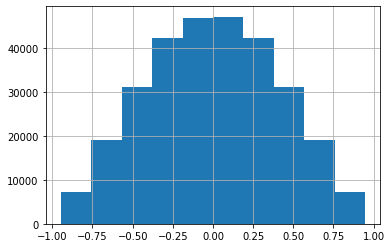

In [14]:
pd.Series(y).hist()

In [15]:
#X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X = np.reshape(X, (X.shape[0], X.shape[1]))

In [16]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()


model.add(Dense(10, input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Activation('relu'))
'''
model.add(Conv1D(12, 9, input_shape=(X.shape[1], 1)))
model.add(Activation('sigmoid'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 3))
model.add(Activation('sigmoid'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 3))
model.add(Activation('sigmoid'))
#model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(20))
model.add(Activation('sigmoid'))
#model.add(Dropout(0.3))
'''

model.add(Dense(1))
model.add(Activation('tanh'))



model.compile(loss='mean_squared_error',
      optimizer='RMSprop',
      metrics=['accuracy'])
          

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1310      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


In [19]:
y

array([0.7213355 , 0.91157454, 0.2720067 , ..., 0.6780719 , 0.4854268 ,
       0.8479969 ], dtype=float32)

In [18]:
checkpointer = ModelCheckpoint(filepath='/tmp/weights.best.hdf5', 
                        verbose=1, save_best_only=True)
model.fit(X, y, 
    batch_size=32, epochs=5, validation_split=0.1, callbacks=[checkpointer])

Epoch 1/5
8270/8273 [============================>.] - ETA: 0s - loss: 0.4729 - accuracy: 5.8192e-04
Epoch 00001: val_loss improved from inf to 0.41732, saving model to /tmp/weights.best.hdf5
8273/8273 [==============================] - 13s 2ms/step - loss: 0.4729 - accuracy: 5.8173e-04 - val_loss: 0.4173 - val_accuracy: 5.4394e-04
Epoch 2/5
8259/8273 [============================>.] - ETA: 0s - loss: 0.4560 - accuracy: 6.1297e-04
Epoch 00002: val_loss improved from 0.41732 to 0.41198, saving model to /tmp/weights.best.hdf5
8273/8273 [==============================] - 14s 2ms/step - loss: 0.4559 - accuracy: 6.1195e-04 - val_loss: 0.4120 - val_accuracy: 5.4394e-04
Epoch 3/5
8273/8273 [==============================] - ETA: 0s - loss: 0.4374 - accuracy: 6.1195e-04
Epoch 00003: val_loss improved from 0.41198 to 0.39861, saving model to /tmp/weights.best.hdf5
8273/8273 [==============================] - 15s 2ms/step - loss: 0.4374 - accuracy: 6.1195e-04 - val_loss: 0.3986 - val_accuracy: 5

In [19]:
from dill import dump, load
#dump(model.get_weights(), open('/tmp/weights.pkl', 'wb'))
model.save('/tmp/model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/model/assets


In [20]:
X_test, y_test, back_idx = make_Xy(df_test, train=False)

In [21]:
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

In [22]:
predictions = model.predict(X_test)

In [ ]:
predictions

In [23]:
df_test['score'] = 0
df_test['pn'] = 0
df_test['stash'] = 0

In [25]:

for i in tqdm(range(len(predictions))):
    
    df_test.loc[ back_idx[i][0], 'score' ] = df_test.loc[ back_idx[i][0], 'score' ] + predictions[i]
    

In [44]:
from cataclop.ml.exploration import random_race

random_race(df_test, ['position', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'score', 'pn']).sort_values(by='score')

position     sub_category  num  final_odds  final_odds_ref  \
race_id                                                                    
63530   4348       3.0  HANDICAP_DIVISE    1         8.7       -0.062069   
        4349      12.0  HANDICAP_DIVISE    2         5.7       -0.524138   
        4359      11.0  HANDICAP_DIVISE   12        44.8        0.903448   
        4360       6.0  HANDICAP_DIVISE   13        58.5        1.979310   
        4357       4.0  HANDICAP_DIVISE   10        25.7        0.137931   
        4355       2.0  HANDICAP_DIVISE    8        27.6        0.331034   
        4354       7.0  HANDICAP_DIVISE    7        18.9        0.200000   
        4358      13.0  HANDICAP_DIVISE   11        19.0        0.103448   
        4356       9.0  HANDICAP_DIVISE    9         9.2       -0.144828   
        4353       8.0  HANDICAP_DIVISE    6        15.1       -0.206897   
        4350      10.0  HANDICAP_DIVISE    3         7.2       -0.358621   
        4352       4.0  HANDICAP_DIVISE    5         9.4       -0.600000   
        4351       1.0  HANDICAP_DIVISE    4         4.2       -0.524138   

                  score  pn  
race_id                      
63530   4348 -12.000000   0  
        4349 -12.000000   0  
        4359 -12.000000   0  
        4360  -4.569166   0  
        4357  -3.603680   0  
        4355  -3.567754   0  
        4354  -3.548383   0  
        4358  -3.214464   0  
        4356  -3.186793   0  
        4353  -3.076545   0  
        4350  -2.715346   0  
        4352  -2.068138   0  
        4351  -1.994153   0

In [45]:
def fast_bet(r):
    p = 'score'

    s = r.sort_values(by=p, ascending=False)
    o = s.index.sort_values(ascending=True, return_indexer=True)
        
    #idx = (r[p] == r[p].max())
    
    s2 = r.sort_values(by='final_odds_ref')
    o2 = s2.index.sort_values(ascending=True, return_indexer=True)
    
    s3 = r.sort_values(by='final_odds')
    o3 = s3.index.sort_values(ascending=True, return_indexer=True)
        
    r['pn'] = o[1]
    r['oddsrn'] = o2[1]
    r['oddsn'] = o3[1]
    r['pstd'] = r[p].std()
    return r

In [46]:
df_test = df_test.groupby('race_id').apply(fast_bet)

In [78]:
h = df_test

print('win % for pred number #')
for i in range(10):
    if len(h[ (h['pn']==i) & (h['score'] > 0) & (h['position'] > 3)]):
        print(i, len(h[ (h['pn']==i) & (h['score'] > 0) & (h['position'] == 1)]) / len(h[ (h['pn']==i) & (h['score'] > 0) & (h['position'] != 1)]))
    
print('win % for odds ref number #')
for i in range(10):
    if len(h[ (h['oddsrn']==i) & (h['position'] > 3)]):
        print(i, len(h[ (h['oddsrn']==i) & (h['position'] == 1)]) / len(h[ (h['oddsrn']==i) & (h['position'] != 1)]))

print('win % for pred number #, when odds number >')
for i in range(10):
    if len(h[ (h['pn']==i) & (h['oddsn']>i) & (h['position'] > 3)]):
        print(i, len(h[ (h['pn']==i) & (h['oddsn']>i) & (h['position'] <= 1)]) / len(h[ (h['pn']==i) & (h['oddsn']>i) & (h['position'] != 1)]))

win % for pred number #
0 0.1693548387096774
1 0.08035714285714286
2 0.08333333333333333
3 0.14285714285714285
4 0.06756756756756757
5 0.16666666666666666
6 0.1276595744680851
7 0.02564102564102564
8 0.03571428571428571
9 0.25
win % for odds ref number #
0 0.2236842105263158
1 0.14814814814814814
2 0.12048192771084337
3 0.09734513274336283
4 0.09411764705882353
5 0.0855457227138643
6 0.06376811594202898
7 0.05309734513274336
8 0.0705521472392638
9 0.03715170278637771
win % for pred number #, when odds number >
0 0.16778523489932887
1 0.1099476439790576
2 0.11827956989247312
3 0.07936507936507936
4 0.033707865168539325
5 0.046632124352331605
6 0.05649717514124294
7 0.03314917127071823
8 0.045714285714285714
9 0.018072289156626505


In [73]:
df_test['bet'] = np.clip(df_test['oddsn'] + 1, 1, 3) #1 #/ np.clip(df_test['score'], 0, 10)
df_test['profit'] = df_test['bet'] * (df_test['winner_dividend'].fillna(0.)/100.-1.0)# + (df_test['winner_dividend'].fillna(0.)/100.-1.0)

In [74]:
#g = df_test[(df_test['sub_category']=='HANDICAP') & (df_test['oddsrn'] <= df_test['pn']) & (df_test['final_odds_ref'] < 30.) & (df_test['final_odds_ref'] > 1.)].copy()
#df_test[(df_test['pn']==0) & (df_test['pstd']<1.) & (df_test['final_odds_ref'] > 1.) & (df_test['final_odds_ref'] < 30.)]['profit'].describe()

for cat in df_test['sub_category'].value_counts().index:
    print(cat)
    g = df_test[ (df_test['pn']==2) & (df_test['sub_category']==cat) & (df_test['prize'] > 0.3) & (df_test['final_odds'] > 10) ].copy()
    print(g['profit'].describe())

HANDICAP_DIVISE
count    62.000000
mean      2.966129
std      14.205459
min      -3.000000
25%      -3.000000
50%      -3.000000
75%      -3.000000
max      50.700000
Name: profit, dtype: float64
HANDICAP
count     7.000000
mean      1.585714
std      12.132660
min      -3.000000
25%      -3.000000
50%      -3.000000
75%      -3.000000
max      29.100000
Name: profit, dtype: float64
GROUPE_III
count    2.0
mean    -3.0
std      0.0
min     -3.0
25%     -3.0
50%     -3.0
75%     -3.0
max     -3.0
Name: profit, dtype: float64
GROUPE_II
count    2.0
mean    -3.0
std      0.0
min     -3.0
25%     -3.0
50%     -3.0
75%     -3.0
max     -3.0
Name: profit, dtype: float64
GROUPE_I
count     2.000000
mean     12.750000
std      22.273864
min      -3.000000
25%       4.875000
50%      12.750000
75%      20.625000
max      28.500000
Name: profit, dtype: float64


HANDICAP_DIVISE
62
                start_at      horse_name  race_id     prize     sub_category  \
739  2018-03-09 13:47:00         SA TUNA    16074  2.185110  HANDICAP_DIVISE   
816  2018-03-13 16:20:00         TANTRIS    16246  0.757405  HANDICAP_DIVISE   
852  2018-03-15 13:51:00  KING OF SPADES    16327  2.185110  HANDICAP_DIVISE   
874  2018-03-20 13:47:00   BONFIRE HEART    16541  2.185110  HANDICAP_DIVISE   
896  2018-03-20 16:30:00     GOLDEN BUCK    16546  0.757405  HANDICAP_DIVISE   
954  2018-03-29 13:47:00    CASTLE DREAM    16908  2.185110  HANDICAP_DIVISE   
994  2018-03-29 16:29:00  SING SOMETHING    16913  0.757405  HANDICAP_DIVISE   
1028 2018-03-31 16:55:00      SCANDALEUX    16996  0.757405  HANDICAP_DIVISE   
1117 2018-04-16 17:28:00        RAJELINE    17672  0.757405  HANDICAP_DIVISE   
1131 2018-05-07 13:47:00   BONFIRE HEART    18555  2.185110  HANDICAP_DIVISE   

      final_odds  placed_dividend  position  bet  profit  stash  
739         11.0            350.0 

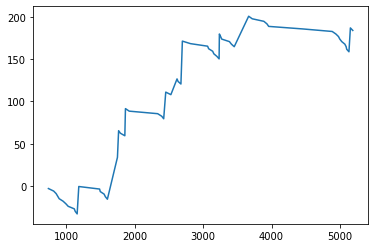

HANDICAP
7
                start_at        horse_name  race_id     prize sub_category  \
495  2018-02-16 15:40:00    DRAGON'S TEETH    15267  0.592539     HANDICAP   
626  2018-02-23 14:37:00       REBEL QUEEN    15539  0.592539     HANDICAP   
1209 2018-05-18 15:41:00    LE TIGRE BLANC    19020  0.504879     HANDICAP   
1840 2018-10-12 15:13:00      SONG OF LIFE    64980  0.504879     HANDICAP   
1929 2018-10-28 14:35:00    SALT LAKE CITY    65728  1.644704     HANDICAP   
3281 2018-06-16 16:30:00      DUC DE MERAN    20278  0.504879     HANDICAP   
5059 2018-10-04 13:25:00  BEYOND MY DREAMS    64607  1.644704     HANDICAP   

      final_odds  placed_dividend  position  bet  profit  stash  
495         11.7              0.0       8.0    3    -3.0   -3.0  
626         15.6              0.0       5.0    3    -3.0   -6.0  
1209        27.5              0.0      13.0    3    -3.0   -9.0  
1840        10.7            380.0       1.0    3    29.1   20.1  
1929        11.3            380.0 

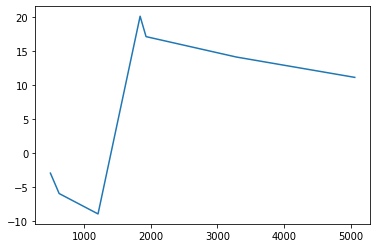

GROUPE_III
2
                start_at        horse_name  race_id     prize sub_category  \
1286 2018-06-17 15:26:00  INFERNAL MAJESTY    20308  3.072424   GROUPE_III   
3621 2018-10-31 14:37:00    FORZA CAPITANO    65905  3.072424   GROUPE_III   

      final_odds  placed_dividend  position  bet  profit  stash  
1286        17.9              0.0       5.0    3    -3.0   -3.0  
3621        10.5            340.0       3.0    3    -3.0   -6.0  


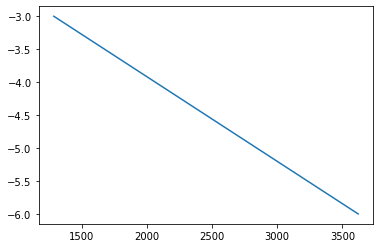

GROUPE_II
2
                start_at horse_name  race_id     prize sub_category  \
1241 2018-06-03 15:36:00     FINCHE    19725  4.072463    GROUPE_II   
2627 2019-06-02 15:40:00     GYLLEN    71992  4.072463    GROUPE_II   

      final_odds  placed_dividend  position  bet  profit  stash  
1241        23.7              0.0       5.0    3    -3.0   -3.0  
2627        11.0              0.0       5.0    3    -3.0   -6.0  


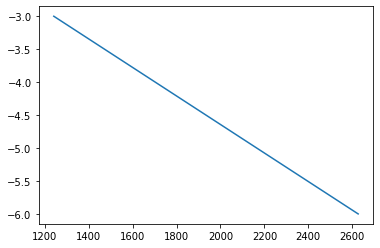

GROUPE_I
2
                start_at horse_name  race_id     prize sub_category  \
1248 2018-06-03 16:15:00  DICE ROLL    19726  9.110075     GROUPE_I   
1293 2018-06-17 16:07:00    LAURENS    20309  8.274898     GROUPE_I   

      final_odds  placed_dividend  position  bet  profit  stash  
1248        13.8              0.0      11.0    3    -3.0   -3.0  
1293        10.5            300.0       1.0    3    28.5   25.5  


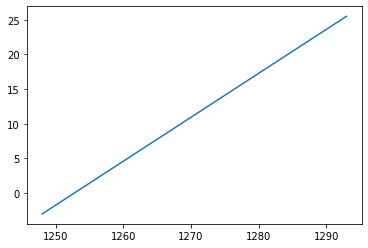

In [77]:
from matplotlib import pyplot as plt
for cat in df_test['sub_category'].value_counts().index:
    print(cat)
    g = df_test[ (df_test['pn']==2) & (df_test['prize'] > 0.3) & (df_test['sub_category']==cat) & (df_test['final_odds'] > 10) ].copy()
    g['stash'] = g['profit'].cumsum()
    pd.set_option('display.max_rows', 1000)
    print(len(g))
    print(g[['start_at', 'horse_name', 'race_id', 'prize', 'sub_category', 'final_odds', 'placed_dividend', 'position', 'bet', 'profit', 'stash']].head(10))
    g['stash'].plot()
    plt.show()

In [ ]:
g['stash'].plot()

In [32]:
from dill import dump, load

dump(scaler, open('/Users/pourquoi/workspace/cataclop/cataclop-django/var/models/keras-pair-pos2/scaler.pkl', 'wb+'))

model.save('/Users/pourquoi/workspace/cataclop/cataclop-django/var/models/keras-pair-pos2/model.h5')

In [24]:
dump(horse_dummies, open('/Users/pourquoi/workspace/cataclop/cataclop-django/var/models/keras-pair-pos2/horse_dummies.pkl', 'wb'))
dump(race_dummies, open('/Users/pourquoi/workspace/cataclop/cataclop-django/var/models/keras-pair-pos2/race_dummies.pkl', 'wb'))